In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    search_query: str


graph_builder = StateGraph(State)

In [ ]:
SYSTEM_PROMPT = """\
Based on the conversation, your task is to create a "search query" that serves \
as a query that can be used in a vector database to give most relevant information to answer the last user's question.

Constrains:
- Create the search query only taking in account the conversation, avoid to add your knowledge.
"""

def generate_search_query(state: State):
    ai_answer = llm.invoke([("system", SYSTEM_PROMPT)] + state["messages"])
    return {
        "search_query": ai_answer.content
    }

graph_builder.add_node("generate_search_query", generate_search_query)
graph_builder.set_entry_point("generate_search_query")
graph_builder.set_finish_point("generate_search_query")
graph = graph_builder.compile()


In [5]:
graph.invoke({"messages": [("user", "quien es susan fletcher en el libro fortaleza digital?")]})

{'messages': [HumanMessage(content='quien es susan fletcher en el libro fortaleza digital?', additional_kwargs={}, response_metadata={}, id='ef8b95c3-d480-4e74-9bfb-2a4f28ce8790')],
 'search_query': 'Susan Fletcher en el libro Fortaleza Digital.'}

# Let's add the db

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    search_query: str
    context: str




In [7]:
import os
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_openai import OpenAIEmbeddings
from langchain_core.runnables import RunnableLambda

url = "https://e7f4684c-fd33-4db0-b1d3-268870ecb84d.europe-west3-0.gcp.cloud.qdrant.io:6333"
api_key = os.getenv("QDRANT_API_KEY")


client = QdrantClient(
    url=url,
    api_key=api_key,
    https=True,
    timeout=300
)

vector_store_page = QdrantVectorStore(
    client=client,
    collection_name="db-book-page",
    embedding=OpenAIEmbeddings(model="text-embedding-ada-002"),
)

In [8]:
from langchain_core.documents import Document
from langgraph.graph import START, END

def combine_documents(documents: list[Document]) -> str:
    return "\n\n".join([document.page_content for document in documents])


SYSTEM_PROMPT = """\
Based on the conversation, your task is to create a "search query" that serves \
as a query that can be used in a vector database to give most relevant information to answer the last user's question.

Constrains:
- Create the search query only taking in account the conversation, avoid to add your knowledge.
"""

def generate_search_query(state: State):
    ai_answer = llm.invoke([("system", SYSTEM_PROMPT)] + state["messages"])
    return {
        "search_query": ai_answer.content
    }

def search_in_db(state: State):
    messages = state["messages"]
    search_query = state["search_query"]

    documents = vector_store_page.similarity_search(search_query, k=5)
    context = combine_documents(documents)
    
    # chain = vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    # context = chain.invoke(search_query)

    return {"context": context}

graph_builder = StateGraph(State)
graph_builder.add_node("generate_search_query", generate_search_query)
graph_builder.add_node("search_in_db", search_in_db)

graph_builder.set_entry_point("generate_search_query")
graph_builder.add_edge("generate_search_query", "search_in_db")
graph_builder.set_finish_point("search_in_db")

graph = graph_builder.compile()


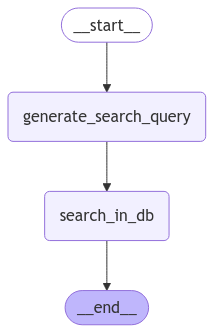

In [9]:
graph

In [10]:
graph.invoke({"messages": [("user", "quien es susan fletcher en el libro fortaleza digital?")]})

{'messages': [HumanMessage(content='quien es susan fletcher en el libro fortaleza digital?', additional_kwargs={}, response_metadata={}, id='17862e07-56b5-4e88-94cb-b7fd85b31fdb')],
 'search_query': 'Susan Fletcher en el libro Fortaleza Digital.',
 'context': 'Dan Brown\nLa fortaleza digital\n\nSusan Fletcher, la criptógrafa estrella de la ultrasecreta Agencia de\nSeguridad Nacional (NSA) no puede dar crédito a sus oídos cuando su jefe,\nel subdirector de la Agencia, le informa de que han interceptado un código\nque ni siquiera la mayor supercomputadora conocida puede descifrar. La\núnica pista para romper el letal código parece estar oculta en el cadáver de\nun hombre que ha fallecido en España, donde ha sido enviado David, el\nprometido de Susan. Mientras éste intenta hallar la clave y sobrevivir a la\npersecución de un metódico e implacable asesino a sueldo en las calles de\nSevilla, Susan se enfrentará a su propio drama en las instalaciones de\nmáxima seguridad de la NSA, durante u

# Let's add the chatbot

In [27]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.documents import Document
from langgraph.graph import START, END
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()


class State(TypedDict):
    messages: Annotated[list, add_messages]
    search_query: str
    context: str
    # answer: str ## no se necesita, se apendara a messages


def combine_documents(documents: list[Document]) -> str:
    return "\n\n".join([document.page_content for document in documents])


REPHRASOR_SYSTEM_PROMPT = """\
Based on the conversation, your task is to create a "search query" that serves \
as a query that can be used in a vector database to give most relevant information to answer the user's question.

Constrains:
- Create the search query only taking in account the conversation, avoid to add your knowledge.
"""

def rephrasor(state: State):
    ai_answer = llm.invoke([("system", REPHRASOR_SYSTEM_PROMPT)] + state["messages"])
    return {
        "search_query": ai_answer.content
    }

def search(state: State):

    chain = vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return {"context": chain.invoke(state["search_query"])}

QA_SYSTEM_PROMPT = """
<PERSONA>
Eres un especialista resolviendo dudas sobre libros de ficción
</PERSONA>

<TAREA>
Tu tarea es responder la pregunta del usuario.
</TAREA>

<RESTRICCIONES>
- Solo responde la pregunta del usuario tomando como contexto lo provisto en <CONTEXTO>.
</RESTRICCIONES>

<CONTEXTO>
{context}
</CONTEXTO>

"""

from langchain_core.messages import SystemMessage

def rag(state: State):
    ai_answer = llm.invoke([SystemMessage(content=QA_SYSTEM_PROMPT.format(context=state["context"]))] + state["messages"])
    return {
        "messages": [ai_answer]
    }




graph_builder = StateGraph(State)
graph_builder.add_node("rephrasor", rephrasor)
graph_builder.add_node("search", search)

graph_builder.add_node("rag", rag)

graph_builder.add_edge(START, "rephrasor")
graph_builder.add_edge("rephrasor", "search")

graph_builder.add_edge("search", "rag")
graph_builder.add_edge("rag", END)
graph = graph_builder.compile(checkpointer=memory)


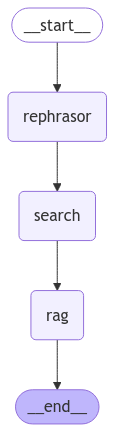

In [28]:
graph

In [ ]:
graph.ainvoke({"messages": [("user", "quien es david becker y que relacion tiene con susan?")]}, config={"configurable": {"thread_id": 2}})

{'messages': [HumanMessage(content='quien es susan fletcher en el libro fortaleza digital?', additional_kwargs={}, response_metadata={}, id='9d1addbc-8c91-4a14-948d-18ef50c63283'),
  AIMessage(content='Susan Fletcher es la criptógrafa estrella de la ultrasecreta Agencia de Seguridad Nacional (NSA) en el libro "La fortaleza digital" de Dan Brown. Ella se enfrenta a un desafío cuando se entera de que han interceptado un código que ni siquiera la mayor supercomputadora puede descifrar. A lo largo de la historia, Susan se ve envuelta en un drama dentro de las instalaciones de la NSA mientras intenta resolver el misterio del código y lidiar con situaciones de peligro y traición.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 105, 'prompt_tokens': 1863, 'total_tokens': 1968, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_

In [ ]:
# tools
# ReAct: Reason, Action and Observe